In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sasmol.sasmol as sasmol
from _cLoops import ffi, lib
from lennard_gofr import *
import matplotlib as mpl
from GV import *
import cPickle as pickle

# Style plots
plt.style.use('ggplot')
mpl.rcParams['figure.figsize']=(16,9)
mpl.rcParams['font.size']=20
mpl.rcParams['axes.labelsize']=25
mpl.rcParams['axes.titlesize']=25
mpl.rcParams['figure.titlesize']=25

# Calculate g(r)

reading filename:  /home/ianhi/smaller_simulation_results/final-arg-5.pdb
num_atoms =  103
>>> found  1  model(s) or frame(s)
finished reading frame =  1
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

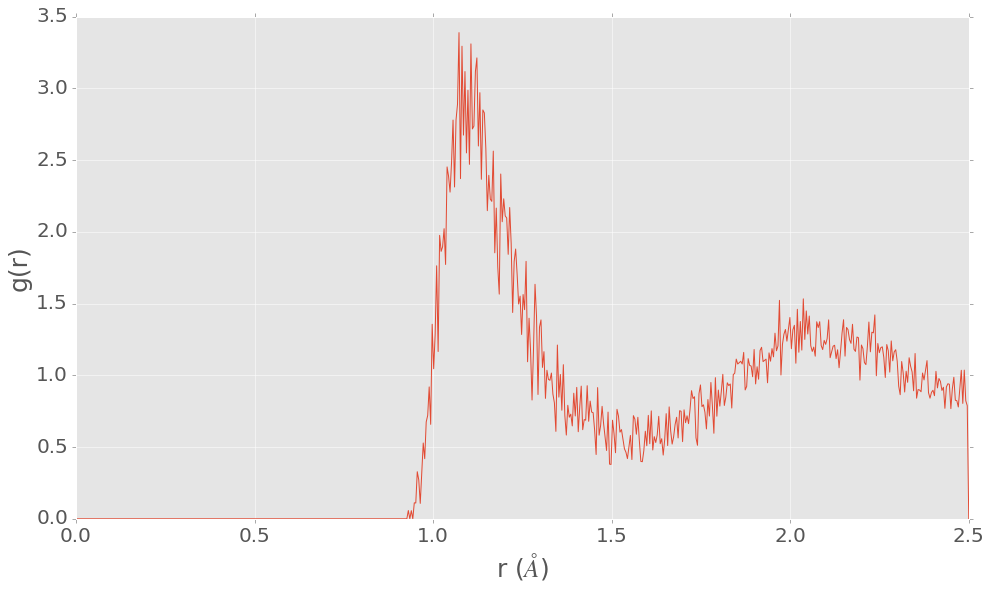

In [3]:
mol = sasmol.SasMol(0)
mol.read_pdb('/home/ianhi/smaller_simulation_results/final-arg-5.pdb')
mol.read_dcd('/home/ianhi/smaller_simulation_results/run_1.dcd')

gc = gofr_calc(mol)


for i in xrange(901,910):
    if i%50==0: print(str(i))
    gc.g_hist(i)
hist = np.copy(gc.g)
r,gr = gc.g_of_r()
plt.xlabel(r'r ($\AA}$)')
plt.ylabel('g(r)')
ax = plt.gca()
# plt.title('g(r) full argon sim')

plt.plot(r,gr)
plt.show()


# Calculate Scattering Averaged over frames

### Utility Function

In [3]:
def cast_matrix(matrix, ffi):
    ap = ffi.new("double* [%d]" % (matrix.shape[0]))
    ptr = ffi.cast("double *", matrix.ctypes.data)
    for i in range(matrix.shape[0]):
        ap[i] = ptr + i*matrix.shape[1]                                                                
    return ap 

### Settings

In [4]:
startFrame = 1
endFrame   =  -1 #-1 = use all
NUM_Q      = 10
START_Q    = -1
END_Q      = 1.6
N_GV       = 35
gv = GV(N_GV).get_golden_vectors()
Q_list = np.logspace(START_Q,END_Q,NUM_Q)

import datetime
print(datetime.datetime.now())

2016-07-21 10:30:22.371550


In [ ]:
coor=mol.coor()[startFrame:endFrame]
num = len(coor[0])

# I = np.zeros((len(coor),len(Q_list)))
for frame in xrange(len(coor)):
    if(frame%50==0):
        print(frame)
    for i,Q in enumerate(Q_list):
        I_tmp = 0
        for g in gv:
            q=g*Q
            cast_coor = cast_matrix(coor[frame],ffi)
            cast_q = ffi.cast('double*',q.ctypes.data)
            I_tmp += lib.sQ(cast_coor,cast_q,num,num)
        I[frame][i] = I_tmp/len(gv)
# pickle.dump( I, open( "multiFrame", "wb" ) )
print(datetime.datetime.now())

In [ ]:
plt.loglog(Q_list,I[0])

In [ ]:
I

In [ ]:
pickle.dump( I, open( "multiFrame", "wb" ) )

In [23]:
a=pickle.load(open('multiFrame10-allFrames','rb'))
a

array([[  3.65219919e+06,   2.45276226e+06,   4.27801888e+05, ...,
          9.91781239e+02,   1.93840063e+03,   2.61042225e+03],
       [  3.65135951e+06,   2.45077617e+06,   4.27114809e+05, ...,
          9.90564209e+02,   1.28777890e+03,   1.72307994e+03],
       [  3.64999858e+06,   2.44726053e+06,   4.24544052e+05, ...,
          1.04403670e+03,   2.13502342e+03,   2.07393734e+03],
       ..., 
       [  3.60142955e+06,   2.31938640e+06,   3.22837672e+05, ...,
          1.83915265e+03,   1.76826861e+03,   1.52468272e+03],
       [  3.60252943e+06,   2.32221399e+06,   3.24810597e+05, ...,
          1.45608991e+03,   2.00279185e+03,   2.17026446e+03],
       [  3.60217782e+06,   2.32131905e+06,   3.24214672e+05, ...,
          1.53614229e+03,   1.21084258e+03,   1.94936968e+03]])

In [29]:
startFrame = 1
endFrame   =  -1 #-1 = use all
NUM_Q      = 100
START_Q    = -1
END_Q      = 1
N_GV       = 35
gv = GV(N_GV).get_golden_vectors()
Q_list = np.logspace(START_Q,END_Q,NUM_Q)

import datetime
print(datetime.datetime.now())

2016-07-18 10:28:20.024035


In [40]:
from multiprocessing import Pool
data_inputs = [0]*4
coor=mol.coor()[startFrame:endFrame]
num = len(coor[0])
N_Q = 100
def process_frame(frame):
    I = np.zeros(len(Q_list))
    for i,Q in enumerate(Q_list):
        I_tmp = 0
        for g in gv:
            q=g*Q
            cast_coor = cast_matrix(coor[frame],ffi)
            cast_q = ffi.cast('double*',q.ctypes.data)
            I_tmp += lib.sQ(cast_coor,cast_q,num,num)
        I[i] = I_tmp/len(gv)
    return I
from functools import partial

partial_frame = partial(process_frame,data_inputs)

In [ ]:
# Q_list = np.logspace(START_Q,END_Q,10)
pool = Pool(processes=5)              # process per core
frames = np.arange(600,1000,1)
I_mp=pool.map(process_frame, frames)
pickle.dump( I_mp, open( "multiFrame-"+str(NUM_Q)+"-allFrames", "wb" ) )
print(datetime.datetime.now())

In [2]:
plt.loglog(Q_list,I_mp[0],label='mp')
a=pickle.load(open('/home/data/Outputs/2016-07-16_00-24/multiFrame-2-999_-1-1.6_250','rb'))
Q_list = np.logspace(-1,1.6,250)
plt.loglog(Q_list,a[990],label='Orig')
plt.legend()

NameError: name 'plt' is not defined

# Debye no PBC

In [5]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))

990
0
100
200
991
0
100
200
992
0
100
200
993
0
100
200
994
0
100
200
995
0
100
200
996
0
100
200


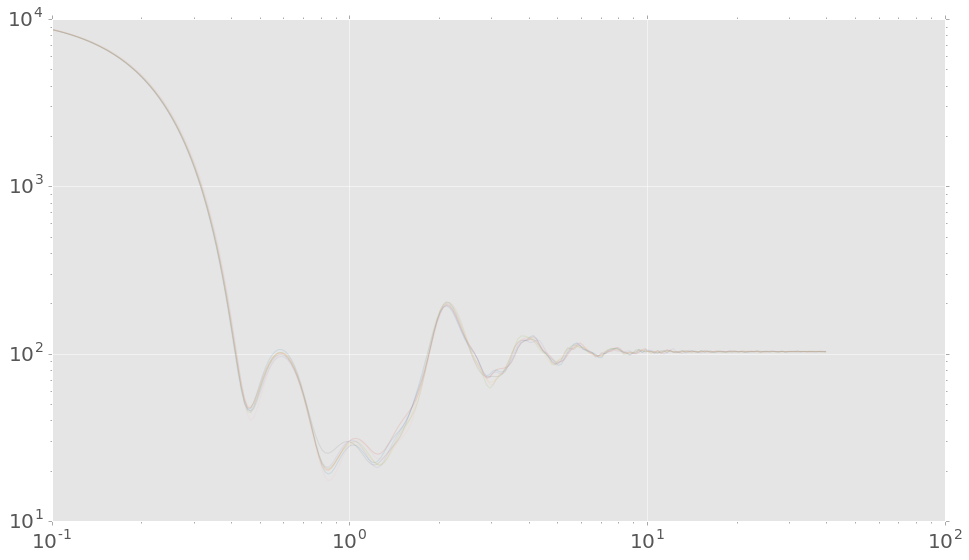

In [7]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))
import periodictable.cromermann as ptc
coor = mol.coor()
# pw = pairwise_numpy(coor)
Q_list  = np.logspace(-1,1.6,250)
I  = np.zeros_like(Q_list)
sld  = np.square(ptc.fxrayatq('Ar',Q_list))
for frame in xrange(990,997):
    print(frame)
    pw = pairwise_numpy(coor[frame])
    for i,q in enumerate(Q_list):
        if(i%100==0): print (i)
        I[i] = np.nansum(np.sinc(q*pw))
    plt.loglog(Q_list,I,alpha=.15)


# All Numpy Exp?

In [5]:
coor = mol.coor()[-2]
i, j = np.triu_indices(len(coor), 1)
# i,j=np.indices((len(coor),1))
displacements = coor[i] - coor[j]
print(displacements)

[[ -2.63038921   2.59858465  10.33462   ]
 [  8.75364161   1.54529905   2.44297838]
 [  4.85158813   0.12340975  -1.55509996]
 ..., 
 [ -1.69661522  -1.07070541  12.71783018]
 [  8.630795     2.33927572   0.32286692]
 [ 10.32741022   3.40998113 -12.39496326]]


In [20]:
i,j=np.indices((len(coor),1))
len(coor[i]-coor[j])
disp = np.zeros((len(coor),len(coor),3))
for i in xrange(len(coor)):
    for j in xrange(len(coor)):
        disp[i][j] = coor[i]-coor[j]

In [61]:
a=np.array([1,2])
b=np.array([[11,12],[13,14],[13,14]])
# print(np.dot(a,b))
print(' ')
print(np.inner(a,b))
print(1*11+2*12)
print(1*13+2*14)
np.inner([2,4,5],disp).size
print(np.inner([1,1,2],disp)[1])
print(np.inner([1,1,2],disp[1]))
print(np.inner([1,1,2],disp).shape)

 
[35 41 41]
35
41
[-20.63743544   0.          -5.45253801 ..., -19.35159969   3.31674004
  -7.73579514]
[-20.63743544   0.          -5.45253801 ..., -19.35159969   3.31674004
  -7.73579514]
(2048, 2048)


In [56]:
2048*2048

4194304

In [67]:
import numexpr as ne
len(disp[0])
Q_list = np.logspace(-1,1.6,50)
N_GV       = 35
gv = GV(N_GV).get_golden_vectors()
I_exp=np.zeros_like(Q_list)
for i,Q in enumerate(Q_list):
    if(i%5==0): print(i)
    for g in gv:
        q = g*Q
        inner = np.inner(q,disp)
        for j in xrange(len(disp)):
            inner_=inner[j]
            #I_exp[i] = np.sum(ne.evaluate("cos(inner)"))#np.cos(np.inner(q,disp[j])))
            I_exp[i] += ne.evaluate("sum(cos(inner_))")
I_exp/=len(gv)
print(I_exp)

0
5
10
15
20


KeyboardInterrupt: 

In [3]:
import numpy as np
import numexpr as ne
import sasmol.sasmol as sasmol
mol = sasmol.SasMol(0)
mol.read_pdb('Data/run_0.pdb')
mol.read_dcd('Data/run_1.dcd')
from GV import *

coor = mol.coor()[900]
Q_list = np.logspace(-1,1.6,50)
N_GV       = 35
gv = GV(N_GV).get_golden_vectors()

disp = np.zeros((len(coor),len(coor),3))
for i in xrange(len(coor)):
    for j in xrange(len(coor)):
        disp[i][j] = coor[i]-coor[j]


reading filename:  Data/run_0.pdb
num_atoms =  2048
>>> found  1  model(s) or frame(s)
finished reading frame =  1
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [5]:

def neTimeLoop():
    Q=1
    I_exp = 0
    for g in gv:
        q = g*Q
        inner = np.inner(q,disp)
        for j in xrange(len(disp)):
            inner_=inner[j]
            #I_exp[i] = np.sum(ne.evaluate("cos(inner)"))#np.cos(np.inner(q,disp[j])))
            I_exp += ne.evaluate("sum(cos(inner_))")
    return I_exp

%timeit neTimeLoop()

1 loop, best of 3: 7.08 s per loop


In [29]:
def neTimeLoop2():
    Q=1
    I_exp = 0
    for g in gv:
        q = g*Q
        inner = np.inner(q,disp)
        I_exp += ne.evaluate("sum(cos(inner))")
#         inner_=inner[5]
#         for j in xrange(len(disp)):
#             inner_=inner[j]
            #I_exp[i] = np.sum(ne.evaluate("cos(inner)"))#np.cos(np.inner(q,disp[j])))

    return I_exp
%timeit neTimeLoop2()

1 loop, best of 3: 6.27 s per loop


In [8]:
def npTimeLoop(Q=1):
    I_exp = 0
    for g in gv:
        q = g*Q
        inner = np.inner(q,disp)
        for j in xrange(len(disp)):
            I_exp += np.sum(np.cos(inner[j]))
    return I_exp
%timeit npTimeLoop(1)

1 loop, best of 3: 6.4 s per loop


In [19]:
def npTimeLoop2(Q=1):
    I_exp = 0
    for g in gv:
        q = g*Q
#         inner = np.inner(q,disp)
        I_exp += np.sum(np.cos(np.inner(q,disp)))
#         for j in xrange(len(disp)):
#             I_exp += np.sum(np.cos(inner[j]))
    return I_exp
%timeit npTimeLoop2(1)

1 loop, best of 3: 6.2 s per loop


In [25]:
from numba import jit
@jit
def npTimeLoopJit(Q=1):
    I_exp = 0
    for g in gv:
        q = g*Q
#         inner = np.inner(q,disp)
        I_exp += np.sum(np.cos(np.inner(q,disp)))
#         for j in xrange(len(disp)):
#             I_exp += np.sum(np.cos(inner[j]))
    return I_exp
%timeit npTimeLoopJit(1)

1 loop, best of 3: 6.31 s per loop


In [35]:
from _cLoops import ffi, lib
def cast_matrix(matrix, ffi):
    ap = ffi.new("double* [%d]" % (matrix.shape[0]))
    ptr = ffi.cast("double *", matrix.ctypes.data)
    for i in range(matrix.shape[0]):
        ap[i] = ptr + i*matrix.shape[1]
    return ap
def cffiLoop(Q=1):
    I_tmp = 0
#     frame=900
    num=len(coor)
    for g in gv:
        q=g*Q
#         print(q)
#         print(coor[frame])
        cast_coor = cast_matrix(coor,ffi)
        cast_q = ffi.cast('double*',q.ctypes.data)
        I_tmp += lib.sQ(cast_coor,cast_q,num,num)
    return I_tmp
%timeit cffiLoop()

1 loop, best of 3: 4.87 s per loop


In [22]:
def npTimeLoop2(Q=1):
    I_exp = 0
    for g in gv:
        q = g*Q
#         inner = np.inner(q,disp)
        I_exp += np.sum(np.cos(np.inner(q,disp)))
#         for j in xrange(len(disp)):
#             I_exp += np.sum(np.cos(inner[j]))
    return I_exp
def npExp(Q):
    I = 0
    for g in gv:
        q = g*Q
        I += np.sum(np.cos(np.inner(q,disp)))
    return I/len(gv)
I_exp = np.zeros_like(Q_list)
for i,Q in enumerate(Q_list):
    if(i%5 ==0): print(i)
    I_exp[i] = npExp(Q)

0
5
10
15
20
25
30
35
40
45


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
mpl.rcParams['figure.figsize']=(16,9)
mpl.rcParams['font.size']=20
mpl.rcParams['axes.labelsize']=25
mpl.rcParams['axes.titlesize']=25
mpl.rcParams['figure.titlesize']=25

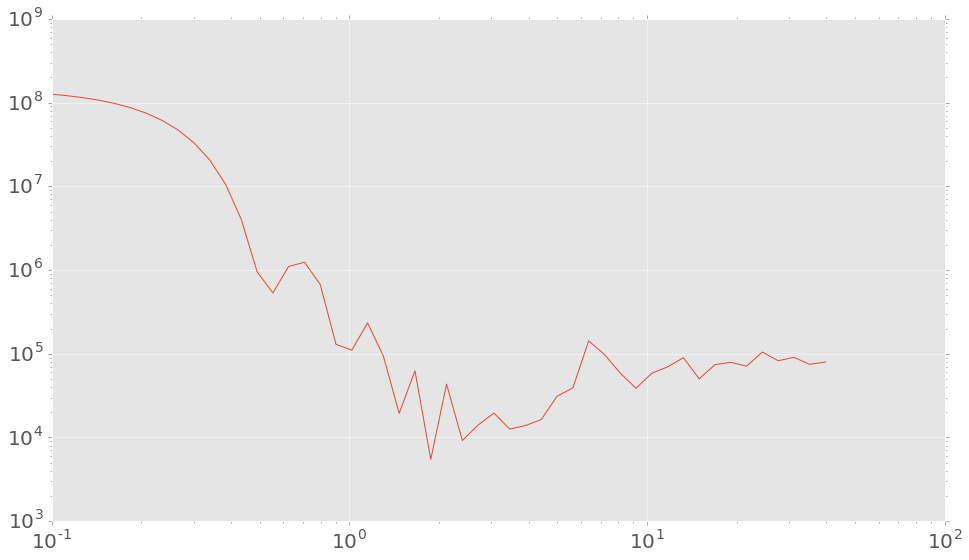

In [28]:
plt.loglog(Q_list,I_exp,label='numpy Exp')
plt.show()

In [17]:
q=[.3,.1,.1]
inner = np.inner(q,disp)
print(inner)
print('\n\n')
print(np.sum(np.cos(inner)))
print(' ')
print(np.apply_along_axis)

[[ 0.          3.40517318  2.08166494 ..., -0.37750685 -1.13801847
   2.30560313]
 [-3.40517318  0.         -1.32350824 ..., -3.78268003 -4.54319165
  -1.09957005]
 [-2.08166494  1.32350824  0.         ..., -2.4591718  -3.21968341
   0.22393819]
 ..., 
 [ 0.37750685  3.78268003  2.4591718  ...,  0.         -0.76051161
   2.68310999]
 [ 1.13801847  4.54319165  3.21968341 ...,  0.76051161  0.          3.4436216 ]
 [-2.30560313  1.09957005 -0.22393819 ..., -2.68310999 -3.4436216   0.        ]]



628576.696585
 
<function apply_along_axis at 0x7f5a41660410>


In [67]:
i, j = np.triu_indices(len(coor), 0)
print(i,j)
print(len(i))
print(len(j))

(array([   0,    0,    0, ..., 2046, 2046, 2047]), array([   0,    1,    2, ..., 2046, 2047, 2047]))
2098176
2098176


In [75]:
displacements

array([[ -2.63038921,   2.59858465,  10.33462   ],
       [  8.75364161,   1.54529905,   2.44297838],
       [  4.85158813,   0.12340975,  -1.55509996],
       ..., 
       [ -1.69661522,  -1.07070541,  12.71783018],
       [  8.630795  ,   2.33927572,   0.32286692],
       [ 10.32741022,   3.40998113, -12.39496326]])

0


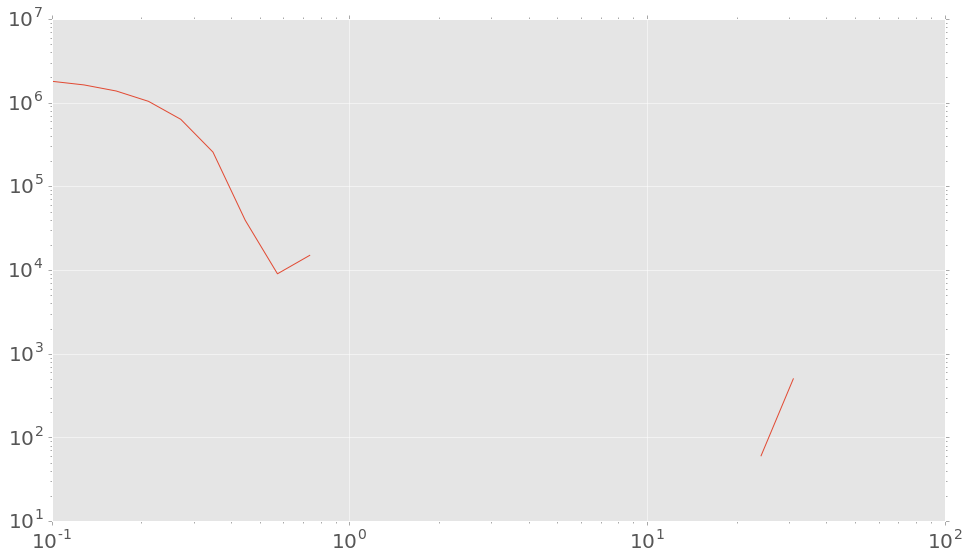

In [86]:
Q_list = np.logspace(-1,1.6,25)
I_exp =  np.zeros_like(Q_list)
for i,Q in enumerate(Q_list):
    if(i%25==0): print(i)
    for g in gv:
        q = g*Q
        I_exp[i] += np.sum(np.cos(np.inner(q,displacements)))
I_exp /= len(gv)
plt.loglog(Q_list,I_exp)

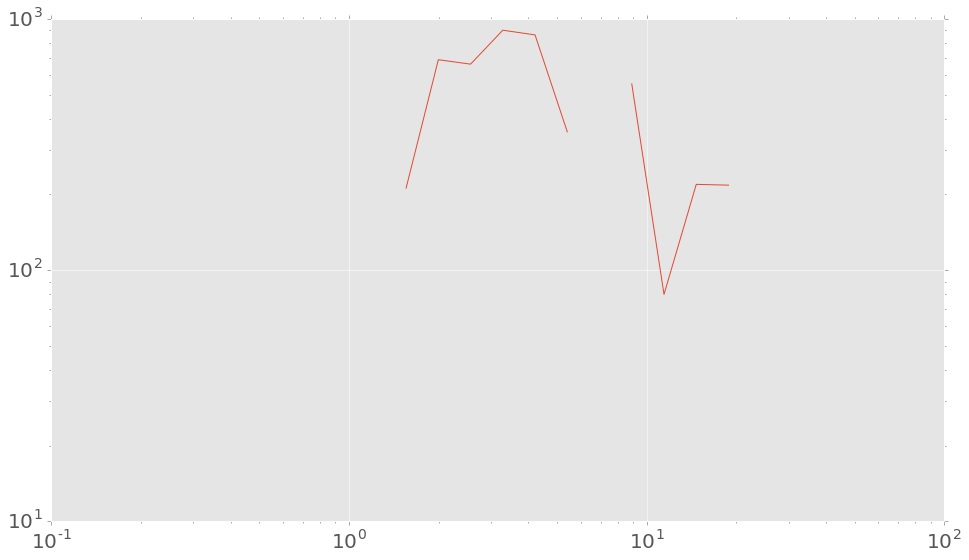

In [87]:
plt.loglog(Q_list,-I_exp)

In [85]:
%timeit np.sum(np.cos(np.inner(q,displacements)))

10 loops, best of 3: 49.7 ms per loop


In [40]:
np.dot(q,np.transpose(displacements))

array([-0.93901206, -0.44337719,  0.03614243, ..., -1.19626456,
       -0.23373187,  0.96253269])

In [10]:
Q_list

array([  0.1       ,   0.19448624,   0.37824899,   0.73564225,
         1.43072299,   2.7825594 ,   5.41169527,  10.52500285,
        20.46968272,  39.81071706])

In [36]:
print(type(np.mat(q)))

<class 'numpy.matrixlib.defmatrix.matrix'>


In [ ]:
q=np.array([1,2,3])
disp  = np.array([[1,1,1],[2,2,2],[3,3,3],[3,3,3]])
for i in displacements:
    print(np.dot(q,i))

33.5706400871
19.1731748581
0.433107733727
9.48816643655
23.4374067783
-1.54182243347
26.4522542953
-0.262591362
36.3965294361
21.4745645523
3.89771223068
28.2065256238
28.2700657845
19.7653772831
7.11896115541
30.1022801399
16.9464073181
31.020049572
28.1239148378
59.0846078396
29.5596387275
20.9237575531
50.1134154797
12.698735714
25.188151598
24.973212719
25.5686439872
15.5489671975
55.4771734476
14.9538636208
13.6682956219
12.4055862278
18.7214198112
22.9777021408
23.3477197886
13.4713919461
16.5448145494
50.9869749546
12.1231425107
15.6318788528
23.2934868336
15.680160284
17.0311357751
52.2909097672
11.1943695545
41.1643719673
8.22354900837
7.52833533287
17.7947605848
21.8576478958
13.5303778648
51.1092667878
8.65306276083
6.24291229248
10.2315315008
1.82596254349
32.5593934059
12.7609901428
27.1933159828
3.66717717052
5.93469449878
7.94688344002
5.21690583229
-1.3186583519
45.2854967117
58.5623819828
41.8396372795
61.2415990829
3.62559294701
31.8090673685
24.259540081
52.42610359

In [55]:
np.inner(q,displacements)

array([ 33.57064009,  19.17317486,   0.43310773, ...,  34.3154645 ,
        14.27794719, -20.03751731])

In [49]:
disp

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [3, 3, 3]])

In [52]:
displacements

array([[ -2.63038921,   2.59858465,  10.33462   ],
       [  8.75364161,   1.54529905,   2.44297838],
       [  4.85158813,   0.12340975,  -1.55509996],
       ..., 
       [ -1.69661522,  -1.07070541,  12.71783018],
       [  8.630795  ,   2.33927572,   0.32286692],
       [ 10.32741022,   3.40998113, -12.39496326]])

In [51]:
np.dot(q,displacements)

ValueError: shapes (3,) and (2096128,3) not aligned: 3 (dim 0) != 2096128 (dim 0)

In [88]:
import numexpr as ne